# RAGAS Evaluation para LangChain Agents

In [1]:
!python --version

Python 3.12.4


**R**etrieval **A**ugmented **G**eneration **As**sessment (RAGAS) es un framework de evaluación diseñado para cuantificar el rendimiento de nuestros pipelines RAG (Retrieval-Augmented Generation). En este ejemplo, veremos cómo usarlo con un agente conversacional habilitado con RAG utilizando LangChain.

Dado que necesitamos tanto un agente como un pipeline RAG para poder evaluar con RAGAS, la primera parte de este notebook se centra en configurar un agente con RAG. Si lo deseás, podés avanzar directamente a la sección **Integrando RAGAS** para ver el uso de RAGAS.

Para comenzar, instalemos los requisitos previos:

In [2]:
!pip install -qU langchain chromadb ragas datasets python-dotenv


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from dotenv import load_dotenv
import os

# Cargar variables del archivo .env
load_dotenv()

# Verifica si se cargó correctamente (opcional)
assert os.getenv("OPENAI_API_KEY") is not None, "Falta la clave de OpenAI"

## Fuente de conocimientos

Lo primero que necesitamos para un agente que utilice RAG es una fuente desde la cual recuperar conocimiento. En este caso, utilizaremos la versión 2 del dataset **AI ArXiv**, disponible en Hugging Face Datasets en [`jamescalam/ai-arxiv2-chunks`](https://huggingface.co/datasets/jamescalam/ai-arxiv2-chunks).

_Nota: estamos usando el dataset ya preprocesado en fragmentos (prechunked). Para acceder a la versión sin procesar, consultá [`jamescalam/ai-arxiv2`](https://huggingface.co/datasets/jamescalam/ai-arxiv2)._


In [4]:
from tqdm.auto import tqdm
from datasets import load_dataset

dataset = load_dataset("jamescalam/ai-arxiv2-chunks", split="train[:20000]")
dataset

c:\Users\aguro\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['doi', 'chunk-id', 'chunk', 'id', 'title', 'summary', 'source', 'authors', 'categories', 'comment', 'journal_ref', 'primary_category', 'published', 'updated', 'references'],
    num_rows: 20000
})

In [5]:
dataset[1]

{'doi': '2401.09350',
 'chunk-id': 1,
 'chunk': 'These neural networks and their training algorithms may be complex, and the scope of their impact broad and wide, but nonetheless they are simply functions in a high-dimensional space. A trained neural network takes a vector as input, crunches and transforms it in various ways, and produces another vector, often in some other space. An image may thereby be turned into a vector, a song into a sequence of vectors, and a social network as a structured collection of vectors. It seems as though much of human knowledge, or at least what is expressed as text, audio, image, and video, has a vector representation in one form or another.\nIt should be noted that representing data as vectors is not unique to neural networks and deep learning. In fact, long before learnt vector representations of pieces of dataâ\x80\x94what is commonly known as â\x80\x9cembeddingsâ\x80\x9dâ\x80\x94came along, data was often encoded as hand-crafted feature vectors. E

## Construcción de la Base de Conocimiento

Para construir nuestra base de conocimiento necesitamos _dos cosas_:

1. **Embeddings**: en este ejemplo utilizamos `OpenAIEmbeddings` con el modelo `text-embedding-3-small` de OpenAI.
2. **Una base de datos vectorial**, donde almacenamos los embeddings y realizamos consultas. Usamos **Chroma** como almacenamiento persistente local.

Además, usamos la librería `tiktoken` para calcular la cantidad de tokens total y estimar el costo de los embeddings antes de ejecutarlo.


In [61]:
import tiktoken

# Cargar dataset (ajustá el split según lo que uses)
data = dataset.to_pandas()

# Lista de textos
texts = data["chunk"].tolist()

# Calcular tokens por texto con tiktoken
enc = tiktoken.encoding_for_model("text-embedding-3-small")
token_counts = [len(enc.encode(text, disallowed_special=())) for text in texts]

# Total
total_tokens = sum(token_counts)
cost_per_1M = 0.02
estimated_cost_usd = (total_tokens / 1000000) * cost_per_1M

print(f"Tokens totales: {total_tokens}")
print(f"Costo estimado: ${estimated_cost_usd:.6f} USD")

Tokens totales: 5027645
Costo estimado: $0.100553 USD


In [63]:
from langchain_community.vectorstores import Chroma
from langchain.embeddings import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Chroma(persist_directory="chroma_db", embedding_function=embedding_function)

### Poblando nuestra base de datos vectorial

Ahora nuestra base de conocimiento está lista para ser poblada con los datos.

Vamos a agregar los documentos a la base de datos vectorial (`Chroma`), que internamente calculará los embeddings usando el modelo `text-embedding-3-small` de OpenAI.

Además, incluimos los metadatos de cada documento, como el título y la fuente, para facilitar búsquedas y trazabilidad futuras.

`Nota: Antes de insertar los textos en la base vectorial, aplicamos una pequeña función de limpieza. Esta función remueve el token especial <|endoftext|>, que a veces aparece al final de ciertos textos generados por modelos de lenguaje. Este token no aporta información semántica útil y puede interferir en el proceso de embedding o recuperación si se deja tal cual.

Al reemplazarlo por un espacio y eliminar espacios sobrantes con .strip(), aseguramos que los textos estén limpios y normalizados antes de ser embebidos y almacenados.`


In [9]:
batch_size = 100

def clean_special_tokens(text):
    return text.replace("<|endoftext|>", " ").strip()

# Ver textos ya cargados
existing_docs = vectorstore.get()
existing_texts = set(existing_docs["documents"])

for i in tqdm(range(0, len(data), batch_size)):
    i_end = min(len(data), i + batch_size)
    batch = data.iloc[i:i_end]

    texts = batch["chunk"].tolist()
    metadatas = batch[["source", "title", "chunk"]].to_dict(orient="records")

    # Filtrar textos que no están ya en la base
    new_texts_and_metas = [
        (clean_special_tokens(t), m) for t, m in zip(texts, metadatas) if t not in existing_texts
    ]

    if new_texts_and_metas:
        new_texts, new_metas = zip(*new_texts_and_metas)
        vectorstore.add_texts(texts=list(new_texts), metadatas=list(new_metas))

100%|██████████| 200/200 [00:04<00:00, 47.10it/s]


Creamos una herramienta (tool) que pueda utilizar nuestro agente para buscar papers de ArXiv:

In [64]:
from langchain.agents import tool

@tool
def arxiv_search(query: str) -> str:
    """Use this tool when answering questions about AI, machine learning, data
    science, or other technical questions that may be answered using arXiv papers.
    """
    # Buscar en Chroma
    results = vectorstore.similarity_search(query, k=5)
    
    # Convertir resultados en string legible
    results_str = "\n---\n".join([doc.page_content for doc in results])
    
    return results_str

tools = [arxiv_search]

Cuando el agente use esta tool, se ejecutará de la siguiente manera:

In [11]:
print(
    arxiv_search.run(tool_input={"query": "can you tell me about llama 2?"})
)

Ethical Considerations and Limitations (Section 5.2) Llama 2 is a new technology that carries risks with use. Testing conducted to date has been in English, and has not covered, nor could it cover all scenarios. For these reasons, as with all LLMs, Llama 2âs potential outputs cannot be predicted in advance, and the model may in some instances produce inaccurate or objectionable responses to user prompts. Therefore, before deploying any applications of Llama 2, developers should perform safety testing and tuning tailored to their speciï¬c applications of the model. Please see the Responsible Use Guide available available at https://ai.meta.com/llama/responsible-user-guide
Table 52: Model card for Llama 2.
77
---
# GenAI, Meta
# Abstract
In this work, we develop and release Llama 2, a collection of pretrained and ï¬ne-tuned large language models (LLMs) ranging in scale from 7 billion to 70 billion parameters. Our ï¬ne-tuned LLMs, called Llama 2-Chat, are optimized for dialogue use c

## Definiento el Agente

Definimos el agente ReAct:

In [34]:
from langchain.chat_models import ChatOpenAI
from langchain.agents import Tool, initialize_agent, AgentType
from langchain.memory import ConversationBufferMemory

# Definimos el historial de conversación.
memory = ConversationBufferMemory(
                                memory_key="chat_history",
                                return_messages=True,
                                output_key="output"
                                )

# Definí tus herramientas (ejemplo)
tools = [
    Tool(name="arxiv_search", func=arxiv_search, description="Buscar papers en ArXiv"),
    # agregá más tools si tenés
]

# Usá GPT‑4.1 nano como LLM
llm = ChatOpenAI(model_name="gpt-4.1-nano", temperature=0)

# Inicializá el agente con RETRIEVE‑THINK‑ACT (ReAct)
agent_executor = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.CHAT_CONVERSATIONAL_REACT_DESCRIPTION,
    memory=memory,
    verbose=True,
    return_intermediate_steps=True
)

Definimos la función 'chat' para facilitar el manejo de las salidas, contextos y pasos intermedios.

In [35]:
def chat(text: str):
    # Ejecutamos el agente
    result = agent_executor.invoke({"input": text})
    
    # Respuesta final del agente
    output = result["output"]
    
    # Recopilamos los pasos intermedios (herramienta + observación)
    steps = result.get("intermediate_steps", [])
    
    # Extraemos contextos: herramienta -> respuesta
    contexts = [obs for (action, obs) in steps]
    
    # Imprimimos para lograr mayor claridad
    print(f"💬 Usuario: {text}")
    print(f"🤖 Respuesta: {output}")
    if contexts:
        print("🧠 Contextos recuperados:")
        for idx, c in enumerate(contexts, start=1):
            print(f"  {idx}. {c[:200].replace(chr(10), ' ')}{'...' if len(c)>200 else ''}")
    else:
        print("⚠️ No se recuperaron contextos.")
    
    # Retornamos todo para evaluación posterior
    return {"output": output, "contexts": contexts, "intermediate_steps": steps}

In [36]:
print(chat("Can you tell me about llama 2?")["output"])



> Entering new AgentExecutor chain...
```json
{
    "action": "arxiv_search",
    "action_input": "Llama 2 language model"
}
```
Observation: We are releasing the following models to the general public for research and commercial useâ¡:
1. Llama 2, an updated version of Llama 1, trained on a new mix of publicly available data. We also increased the size of the pretraining corpus by 40%, doubled the context length of the model, and adopted grouped-query attention (Ainslie et al., 2023). We are releasing variants of Llama 2 with 7B, 13B, and 70B parameters. We have also trained 34B variants, which we report on in this paper but are not releasing.Â§
2. Llama 2-Chat, a ï¬ne-tuned version of Llama 2 that is optimized for dialogue use cases. We release variants of this model with 7B, 13B, and 70B parameters as well.
---
# GenAI, Meta
# Abstract
In this work, we develop and release Llama 2, a collection of pretrained and ï¬ne-tuned large language models (LLMs) ranging in scale from 7 bil

We can ask follow up questions that miss key information but thanks to the conversational history the LLM understands the context and uses that to adjust the search query.

_Note: if missing `"chat_history"` parameter from the `agent` definition you will likely notice a lack of context in the search term, and in some cases this lack of good information can trigger a `ValueError` during output parsing._

In [37]:
out = chat("was any red teaming done?")
print(out["output"])



> Entering new AgentExecutor chain...
```json
{
    "action": "arxiv_search",
    "action_input": "Llama 2 red teaming safety evaluation"
}
```
Observation: . . . . . . . . . . . . . . . 3.4 RLHF Results . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Safety in Pretraining . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 4.2 Safety Fine-Tuning . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 4.3 Red Teaming . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 4.4 Safety Evaluation of Llama 2-Chat . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 5.1 Learnings and Observations . . . . . . . . . . . . . . . . . . . . . . . .
---
In addition to red teaming sessions, we ran a quantitative evaluation on risk from generating malicious code by scoring Code Llamaâs responses to ChatGPTâs (GPT3.5 Turbo) with LLAMAv2 

---

## Integrando RAGAS

Para integrar la evaluación con RAGAS en este pipeline, necesitamos algunas cosas: los contextos recuperados y la salida generada.

Veamos que devuelve `out`:

In [38]:
out

{'output': 'Based on the information available, extensive red teaming was conducted as part of the safety evaluation process for Llama 2. Over 350 internal and external experts participated in proactive risk identification, probing the model across various risk categories and attack vectors, including non-English prompts. The red teaming aimed to identify vulnerabilities and improve robustness before deployment, covering areas such as malicious content, false refusals, and safety in responses. This comprehensive approach highlights the importance placed on safety and robustness in the development of Llama 2.',
 'contexts': ['. . . . . . . . . . . . . . . 3.4 RLHF Results . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Safety in Pretraining . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 4.2 Safety Fine-Tuning . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 4.3 Red Teami

Al inicializar nuestro agente con `return_intermediate_steps=True`, estamos recibiendo automáticamente los pasos intermedios (tuplas de acción y observación) que el agente ejecuta para generar la respuesta final. Esos pasos incluyen la salida del `arxiv_search`, que podemos utilizar para evaluar la fase de recuperación de contexto en nuestro pipeline usando RAGAS.

Extraemos los contextos recuperados de esta forma:

In [41]:
print(out["intermediate_steps"][0][1])

. . . . . . . . . . . . . . . 3.4 RLHF Results . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Safety in Pretraining . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 4.2 Safety Fine-Tuning . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 4.3 Red Teaming . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 4.4 Safety Evaluation of Llama 2-Chat . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 5.1 Learnings and Observations . . . . . . . . . . . . . . . . . . . . . . . .
---
In addition to red teaming sessions, we ran a quantitative evaluation on risk from generating malicious code by scoring Code Llamaâs responses to ChatGPTâs (GPT3.5 Turbo) with LLAMAv2 70Bâs safety reward model. For this second quantitative evaluation, we selected prompts that the red teamers generated specifically attempting to solicit mal

## Evaluación

Para evaluar con RAGAS necesitamos un conjunto de datos que incluya lo siguiente para cada ejemplo:

`question`: la pregunta que se hace al agente,

`contexts`: los contextos identiﬁcados (recuperados por la herramienta, como arxiv_search),

`answer`: la respuesta generada por el agente,

`ground_truth`: la respuesta correcta esperada (“ground truth”) para esa pregunta.

In [42]:
ragas_data = load_dataset("aurelio-ai/ai-arxiv2-ragas-mixtral", split="train")
ragas_data

c:\Users\aguro\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\aguro\.cache\huggingface\hub\datasets--aurelio-ai--ai-arxiv2-ragas-mixtral. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Generating train split: 100%|██████████| 51/51 [00:00<00:00, 3262.11 examples

Dataset({
    features: ['question', 'ground_truth_context', 'ground_truth', 'question_type', 'episode_done'],
    num_rows: 51
})

In [43]:
ragas_data[0]

{'question': 'What is the impact of encoding the input prompt on inference speed in generative inference?',
 'ground_truth_context': ['- This technique works particularly well when processing large batches of data, during train-\ning Pudipeddi et al. (2020); Ren et al. (2021) or large-batch non-interactive inference Aminabadi et al.\n(2022); Sheng et al. (2023), where each layer processes a lot of tokens each time the layer is loaded\nfrom RAM.\n- In turn, when doing interactive inference (e.g. as a chat assistants), offloading works\nsignificantly slower than on-device inference.\n- The generative inference workload consists of two phases: 1) encoding the input prompt and 2)\ngenerating tokens conditioned on that prompt.\n- The key difference between these two phases is that\nprompt tokens are encoded in parallel (layer-by-layer), whereas the generation runs sequentially\n(token-by-token and layer-by-layer).\n- In general, phase 1 works relatively well with existing Mixture-\nof-Exper

Primero iteramos por las preguntas de nuestro dataset de evualiacion y le pedimos a nuestro agente responderlas:

In [44]:
import pandas as pd
from tqdm.auto import tqdm

df = pd.DataFrame({
    "question": [],
    "contexts": [],
    "answer": [],
    "ground_truth": []
})

limit = 5

for i, row in tqdm(enumerate(ragas_data), total=limit):
    if i >= limit:
        break
    question = row["question"]
    ground_truths = row["ground_truth"]
    try:
        out = chat(question)
        answer = out["output"]
        if len(out["intermediate_steps"]) != 0:
            contexts = out["intermediate_steps"][0][1].split("\n---\n")
        else:
            # this is where no intermediate steps are used
            contexts = []
    except ValueError:
        answer = "ERROR"
        contexts = []
    df = pd.concat([df, pd.DataFrame({
        "question": question,
        "answer": answer,
        "contexts": [contexts],
        "ground_truth": ground_truths
    })], ignore_index=True)

  0%|          | 0/5 [00:00<?, ?it/s]



> Entering new AgentExecutor chain...
```json
{
    "action": "arxiv_search",
    "action_input": "impact of encoding input prompt on inference speed in generative models"
}
```
Observation: The generative inference workload consists of two phases: 1) encoding the input prompt and 2) generating tokens conditioned on that prompt. The key difference between these two phases is that prompt tokens are encoded in parallel (layer-by-layer), whereas the generation runs sequentially (token-by-token and layer-by-layer). In general, phase 1 works relatively well with existing Mixture- of-Experts algorithms, since each layer can only be loaded once for the entire prompt. In turn, when generating tokens, one must load layer once per each token generated. In practice, this means that inference speed is limited by how fast one can fetch parameters from system memory.
Below, we look for patterns in how the MoE model loads its experts and propose ways to exploit these patterns to speed up inference 

 20%|██        | 1/5 [00:04<00:18,  4.74s/it]

```json
{
    "action": "Final Answer",
    "action_input": "The impact of encoding the input prompt on inference speed in generative models is significant. Encoding the prompt involves processing the entire input in parallel, which is relatively efficient, especially with techniques like Mixture-of-Experts. However, during token generation, the model must process each token sequentially, loading parameters repeatedly, which can slow down inference. The speed is thus limited by how quickly system memory can fetch parameters, and optimizing expert loading patterns can help improve inference speed."
}
```

> Finished chain.
💬 Usuario: What is the impact of encoding the input prompt on inference speed in generative inference?
🤖 Respuesta: The impact of encoding the input prompt on inference speed in generative models is significant. Encoding the prompt involves processing the entire input in parallel, which is relatively efficient, especially with techniques like Mixture-of-Experts. Howev

 40%|████      | 2/5 [00:09<00:13,  4.56s/it]

```json
{
    "action": "Final Answer",
    "action_input": "Generating tokens sequentially during inference significantly impacts speed because each token must be produced one after the other, rather than in parallel. This token-by-token process introduces latency, as each new token depends on the previous ones, making the overall inference slower. Additionally, the process involves repeatedly loading model parameters for each token, which can further slow down inference depending on system memory access speeds. Optimizations like model compression, efficient hardware, and improved loading strategies can help mitigate these delays."
}
```

> Finished chain.
💬 Usuario: How does generating tokens affect the inference speed in generative inference?
🤖 Respuesta: Generating tokens sequentially during inference significantly impacts speed because each token must be produced one after the other, rather than in parallel. This token-by-token process introduces latency, as each new token depend

 60%|██████    | 3/5 [00:13<00:08,  4.42s/it]

```json
{
    "action": "Final Answer",
    "action_input": "Mixtral 8x7B differs from Mistral 7B primarily in its use of a sparse mixture of experts (SMoE) architecture, where each layer contains 8 feedforward (expert) blocks. During inference, only 13 billion active parameters are used per token, despite the model having access to a total of 47 billion parameters. In contrast, Mistral 7B is a dense model with a standard transformer architecture. This means Mixtral 8x7B can achieve similar or better performance with fewer active parameters during inference, leading to increased efficiency. The architecture modifications in Mixtral, such as the expert routing mechanism, distinguish it from the standard feedforward blocks used in Mistral 7B."
}

> Finished chain.
💬 Usuario: How does the architecture of Mixtral 8x7B differ from Mistral 7B in terms of feedforward blocks and active parameters used during inference?
🤖 Respuesta: Mixtral 8x7B differs from Mistral 7B primarily in its use of a

 80%|████████  | 4/5 [00:17<00:04,  4.29s/it]

```json
{
    "action": "Final Answer",
    "action_input": "Offloading in A100 servers for accelerating MoE-based language models is used during inference, especially when dealing with large models that require more memory than available on the GPU. Techniques such as expert caching, offloading experts to CPU memory, and overlapping expert loading with computation are employed to enable efficient inference on hardware with limited GPU memory. This approach allows models like Mixtral-8x7B to run interactively on consumer-grade hardware by reducing GPU memory usage and improving inference speed."
}
```

> Finished chain.
💬 Usuario: When is offloading used on the A100 server for accelerating MoE-based language models?
🤖 Respuesta: Offloading in A100 servers for accelerating MoE-based language models is used during inference, especially when dealing with large models that require more memory than available on the GPU. Techniques such as expert caching, offloading experts to CPU memory, an

100%|██████████| 5/5 [00:20<00:00,  4.18s/it]

```json
{
    "action": "Final Answer",
    "action_input": "Mixtral 8x7B significantly outperforms Llama 2 70B across most benchmarks, especially in code, mathematics, and reasoning tasks, while using approximately 5 times fewer active parameters during inference. This makes Mixtral more efficient in terms of compute cost, despite having a smaller active parameter count, and it achieves comparable or superior performance on many tasks."
}
```

> Finished chain.
💬 Usuario: How does Mixtral compare to Llama 2 70B in code benchmarks?
🤖 Respuesta: Mixtral 8x7B significantly outperforms Llama 2 70B across most benchmarks, especially in code, mathematics, and reasoning tasks, while using approximately 5 times fewer active parameters during inference. This makes Mixtral more efficient in terms of compute cost, despite having a smaller active parameter count, and it achieves comparable or superior performance on many tasks.
🧠 Contextos recuperados:
  1. Detailed results for Mistral 7B, Llama 

In [45]:
df

,question,contexts,answer,ground_truth
0,What is the impact of encoding the input promp...,[The generative inference workload consists of...,The impact of encoding the input prompt on inf...,The encoding of the input prompt has an impact...
1,How does generating tokens affect the inferenc...,[inference latency since the generation of tok...,Generating tokens sequentially during inferenc...,Generating tokens affects the inference speed ...
2,How does the architecture of Mixtral 8x7B diff...,"[Abstract\nWe introduce Mixtral 8x7B, a Sparse...",Mixtral 8x7B differs from Mistral 7B primarily...,The architecture of Mixtral 8x7B differs from ...
3,When is offloading used on the A100 server for...,"[1When deployed in 16-bit precision, Falcon-18...",Offloading in A100 servers for accelerating Mo...,Offloading is used on the A100 server for acce...
4,How does Mixtral compare to Llama 2 70B in cod...,"[Detailed results for Mistral 7B, Llama 2 7B/1...",Mixtral 8x7B significantly outperforms Llama 2...,Mixtral outperforms Llama 2 70B in code benchm...


In [50]:
from datasets import Dataset
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_precision,
    context_recall,
    answer_similarity,
    answer_correctness,
)

eval_data = Dataset.from_dict(df)
eval_data

Dataset({
    features: ['question', 'contexts', 'answer', 'ground_truth'],
    num_rows: 5
})

In [55]:
from ragas import evaluate

result = evaluate(
    dataset=eval_data,
    metrics=[
        faithfulness,
        answer_relevancy,
        context_precision,
        context_recall,
        answer_similarity,
        answer_correctness,
    ],
)
result = result.to_pandas()

Evaluating: 100%|██████████| 30/30 [00:21<00:00,  1.37it/s]


## Retrieval Metrics / Métricas de Recuperación

La recuperación (retrieval) es el primer paso en un pipeline RAG, por lo que nos enfocaremos primero en las métricas que evalúan la parte de recuperación. Para eso, queremos principalmente centrarnos en `context_recall` y `context_precision`, pero antes de entrar en esas métricas debemos entender qué miden exactamente.

### Condición real ("Actual") vs. Predicha ("Predicted")

Cuando evaluamos el rendimiento de sistemas de recuperación, tendemos a comparar los resultados _reales_ (ground truth) con los resultados _predichos_. Definimos estos términos de la siguiente manera:

- **Condición real** es la etiqueta verdadera de cada contexto en el dataset. Estos son _positivos_ ($p$) si el contexto es relevante para la consulta, o _negativos_ ($n$) si el contexto es _irrelevante_.

- **Condición predicha** es la etiqueta _predicha_ determinada por nuestro sistema de recuperación. Si un contexto es devuelto, es un _positivo predicho_ ($\hat{p}$). Si no es devuelto, es un _negativo predicho_ ($\hat{n}$).

Dadas estas condiciones, podemos decir lo siguiente:

- $p\hat{p}$ es un **verdadero positivo**: un resultado relevante fue devuelto.
- $n\hat{n}$ es un **verdadero negativo**: un resultado irrelevante no fue devuelto.
- $n\hat{p}$ es un **falso positivo**: un resultado irrelevante fue devuelto.
- $p\hat{n}$ es un **falso negativo**: un resultado relevante _no_ fue devuelto.

Veamos ahora cómo se aplican estos conceptos a nuestras métricas en RAGAS.

#### Context Recall

El context recall (o simplemente _recall_) es una medida de cuántos de los documentos relevantes en un conjunto han sido recuperados. Se calcula como:

$$
Recall@K = \frac{p\hat{p}}{p\hat{p} + n\hat{n}} = \frac{Contextos \: relevantes \: recuperados}{Cantidad \: total \: de \: contextos \: relevantes}
$$

RAGAS calcula el _Recall@K_ para evaluar el recall, donde _@K_ representa la cantidad de contextos devueltos por el sistema. A medida que se incrementa el valor de @K, el recall mejora (ya que aumenta la cobertura del sistema de recuperación).

En el extremo, podríamos establecer @K igual al tamaño total del dataset para garantizar un recall perfecto —aunque eso anula el propósito del enfoque RAG.

Por defecto, RAGAS utiliza un valor de _@K_ igual a `5`.

In [56]:
pd.set_option("display.max_colwidth", 700)

# Unimos el dataframe original (df) con las métricas (result)
final_result = pd.concat([df.reset_index(drop=True), result.reset_index(drop=True)], axis=1)

final_result[["question", "contexts", "answer", "context_recall"]]

,question,contexts,answer,context_recall
0,What is the impact of encoding the input prompt on inference speed in generative inference?,"[The generative inference workload consists of two phases: 1) encoding the input prompt and 2) generating tokens conditioned on that prompt. The key difference between these two phases is that prompt tokens are encoded in parallel (layer-by-layer), whereas the generation runs sequentially (token-by-token and layer-by-layer). In general, phase 1 works relatively well with existing Mixture- of-Experts algorithms, since each layer can only be loaded once for the entire prompt. In turn, when generating tokens, one must load layer once per each token generated. In practice, this means that inference speed is limited by how fast one can fetch parameters from system memory.\nBelow, we look for ...","The impact of encoding the input prompt on inference speed in generative models is significant. Encoding the prompt involves processing the entire input in parallel, which is relatively efficient, especially with techniques like Mixture-of-Experts. However, during token generation, the model must process each token sequentially, loading parameters repeatedly, which can slow down inference. The speed is thus limited by how quickly system memory can fetch parameters, and optimizing expert loading patterns can help improve inference speed.",1.0
1,How does generating tokens affect the inference speed in generative inference?,"[inference latency since the generation of tokens cannot be parallelized. There is a bunch of literature addressing the first two axes: large model size (Xiao et al., 2022; Frantar et al., 2022; Lin et al., 2023; Sheng et al., 2023; Wang et al., 2021) and attention operation (Kitaev et al., 2020; Wang et al., 2020; Dao et al., 2022; Zaheer et al., 2020; Chen et al., 2023b). These works either compress/redesign the model (Xiao et al., 2022; Frantar et al., 2022; Lin et al., 2023; Kitaev et al., 2020; Wang et al., 2020; Dao et al., 2022; Zaheer et al., 2020) or redesign the serving system (Sheng et al., 2023; Chen et al., 2023b) and hardware (Wang et al., 2021)., â¢ The average number of ...","Generating tokens sequentially during inference significantly impacts speed because each token must be produced one after the other, rather than in parallel. This token-by-token process introduces latency, as each new token depends on the previous ones, making the overall inference slower. Additionally, the process involves repeatedly loading model parameters for each token, which can further slow down inference depending on system memory access speeds. Optimizations like model compression, efficient hardware, and improved loading strategies can help mitigate these delays.",1.0
2,How does the architecture of Mixtral 8x7B differ from Mistral 7B in terms of feedforward blocks and active parameters used during inference?,"[Abstract\nWe introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model. Mixtral has the same architecture as Mistral 7B, with the difference that each layer is composed of 8 feedforward blocks (i.e. experts). For every token, at each layer, a router network selects two experts to process the current state and combine their outputs. Even though each token only sees two experts, the selected experts can be different at each timestep. As a result, each token has access to 47B parameters, but only uses 13B active parameters during inference. Mixtral was trained with a context size of 32k tokens and it outperforms or matches Llama 2 70B and GPT-3.5 across all evaluated benchm...","Mixtral 8x7B differs from Mistral 7B primarily in its use of a sparse mixture of experts (SMoE) architecture, where each layer contains 8 feedforward (expert) blocks. During inference, only 13 billion active parameters are used per token, despite the model having access to a total of 47 billion parameters. In contrast, Mistral 7B is a dense model with a standard transformer architecture. This mea

Aquí podemos ver que todos los resultados devolvieron un `1.0`, lo cual indica que el 100% de los contextos relevantes fueron recuperados en cada caso.

Como ejemplo hipotético, si se hubiera obtenido un score de `0.6`, eso significaría que se recuperaron 3 de cada 5 contextos relevantes (es decir, un 60%).

El recall es una métrica útil, pero se puede engañar fácilmente si simplemente se devuelven más documentos, es decir, si se incrementa el valor de _@K_. Por este motivo, normalmente se combina con la métrica de precisión (precision).

### Context Precision

La **precisión de contexto** (o simplemente _precisión_) es otra métrica muy popular para evaluar sistemas de recuperación. Es común ver **recall** y **precision** utilizadas en conjunto para evaluar el rendimiento de estos sistemas.

Al igual que con el recall, la métrica real utilizada es _Precision@K_, donde **@K** representa la cantidad de contextos devueltos. Sin embargo, a diferencia del recall, la precisión se enfoca en la **cantidad de resultados relevantes dentro del total de resultados devueltos**, sin importar si los irrelevantes fueron descartados o no. Es decir, mide **la proporción de resultados relevantes entre todos los que se devolvieron**.

$$
Precision@K = \frac{p\hat{p}}{p\hat{p} + p\hat{n}} = \frac{Contextos \: relevantes \: recuperados}{Total \: de \: contextos \: devueltos}
$$


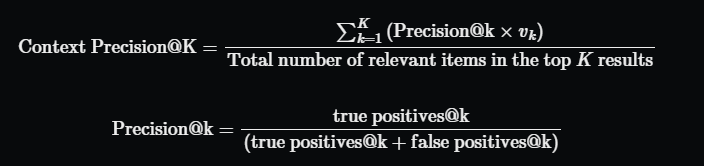

In [57]:
pd.set_option("display.max_colwidth", 700)
final_result[["question", "contexts", "answer", "context_precision"]]

,question,contexts,answer,context_precision
0,What is the impact of encoding the input prompt on inference speed in generative inference?,"[The generative inference workload consists of two phases: 1) encoding the input prompt and 2) generating tokens conditioned on that prompt. The key difference between these two phases is that prompt tokens are encoded in parallel (layer-by-layer), whereas the generation runs sequentially (token-by-token and layer-by-layer). In general, phase 1 works relatively well with existing Mixture- of-Experts algorithms, since each layer can only be loaded once for the entire prompt. In turn, when generating tokens, one must load layer once per each token generated. In practice, this means that inference speed is limited by how fast one can fetch parameters from system memory.\nBelow, we look for ...","The impact of encoding the input prompt on inference speed in generative models is significant. Encoding the prompt involves processing the entire input in parallel, which is relatively efficient, especially with techniques like Mixture-of-Experts. However, during token generation, the model must process each token sequentially, loading parameters repeatedly, which can slow down inference. The speed is thus limited by how quickly system memory can fetch parameters, and optimizing expert loading patterns can help improve inference speed.",0.804167
1,How does generating tokens affect the inference speed in generative inference?,"[inference latency since the generation of tokens cannot be parallelized. There is a bunch of literature addressing the first two axes: large model size (Xiao et al., 2022; Frantar et al., 2022; Lin et al., 2023; Sheng et al., 2023; Wang et al., 2021) and attention operation (Kitaev et al., 2020; Wang et al., 2020; Dao et al., 2022; Zaheer et al., 2020; Chen et al., 2023b). These works either compress/redesign the model (Xiao et al., 2022; Frantar et al., 2022; Lin et al., 2023; Kitaev et al., 2020; Wang et al., 2020; Dao et al., 2022; Zaheer et al., 2020) or redesign the serving system (Sheng et al., 2023; Chen et al., 2023b) and hardware (Wang et al., 2021)., â¢ The average number of ...","Generating tokens sequentially during inference significantly impacts speed because each token must be produced one after the other, rather than in parallel. This token-by-token process introduces latency, as each new token depends on the previous ones, making the overall inference slower. Additionally, the process involves repeatedly loading model parameters for each token, which can further slow down inference depending on system memory access speeds. Optimizations like model compression, efficient hardware, and improved loading strategies can help mitigate these delays.",1.000000
2,How does the architecture of Mixtral 8x7B differ from Mistral 7B in terms of feedforward blocks and active parameters used during inference?,"[Abstract\nWe introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model. Mixtral has the same architecture as Mistral 7B, with the difference that each layer is composed of 8 feedforward blocks (i.e. experts). For every token, at each layer, a router network selects two experts to process the current state and combine their outputs. Even though each token only sees two experts, the selected experts can be different at each timestep. As a result, each token has access to 47B parameters, but only uses 13B active parameters during inference. Mixtral was trained with a context size of 32k tokens and it outperforms or matches Llama 2 70B and GPT-3.5 across all evaluated benchm...","Mixtral 8x7B differs from Mistral 7B primarily in its use of a sparse mixture of experts (SMoE) architecture, where each layer contains 8 feedforward (expert) blocks. During inference, only 13 billion active parameters are used per token, despite the model having access to a total of 47 billion parameters. In contrast, Mistral 7B is a dense model with a standard transformer architect

RAGAS usa embeddings + soft matching, a diferencia de un sistema clásico donde un contexto es relevante o no (1 o 0).

1. Calcula la similitud semántica entre los contextos devueltos y los contextos ideales (ground truths).

2. Usa una métrica como cosine similarity para dar un score continuo (entre 0 y 1) a cada contexto recuperado.

3. Suma esas similitudes para calcular la precisión, en vez de contar solo exact matches.

Entonces, RAGAS no cuenta cuántos son “correctos”, sino que calcula un promedio ponderado,. Si hay un valor menor a 1, significa que algunos de los contextos eran parcialmente relevantes pero no perfectos.

## Generation Metrics / Métricas de Generación

### Faithfullness / Fidelidad

La métrica de _faithfulness_ mide (en un rango de _0_ a _1_) la consistencia factual de una respuesta en relación con el contexto recuperado.  
Un valor de _1_ significa que **todas las afirmaciones** presentes en la respuesta también se encuentran en el contexto.  
Un valor de _0_ indica que **ninguna de las afirmaciones** de la respuesta se encuentra en el contexto.

Calculamos _faithfulness_ de la siguiente manera:

$$
Faithfulness = \frac{Número \: de \: afirmaciones \: en \: la \: respuesta \: que \: también \: están \: en \: el \: contexto}{Número \: total \: de \: afirmaciones \: en \: la \: respuesta}
$$


In [60]:
pd.set_option("display.max_colwidth", 1000)
final_result[["question", "contexts", "answer", "faithfulness"]]

,question,contexts,answer,faithfulness
0,What is the impact of encoding the input prompt on inference speed in generative inference?,"[The generative inference workload consists of two phases: 1) encoding the input prompt and 2) generating tokens conditioned on that prompt. The key difference between these two phases is that prompt tokens are encoded in parallel (layer-by-layer), whereas the generation runs sequentially (token-by-token and layer-by-layer). In general, phase 1 works relatively well with existing Mixture- of-Experts algorithms, since each layer can only be loaded once for the entire prompt. In turn, when generating tokens, one must load layer once per each token generated. In practice, this means that inference speed is limited by how fast one can fetch parameters from system memory.\nBelow, we look for patterns in how the MoE model loads its experts and propose ways to exploit these patterns to speed up inference time.\n4To learn more about these methods, please refer to surveys such as Gholami et al. (2021); Liang et al. (2021) 5As opposed to running a processing a large batch of texts over many ...","The impact of encoding the input prompt on inference speed in generative models is significant. Encoding the prompt involves processing the entire input in parallel, which is relatively efficient, especially with techniques like Mixture-of-Experts. However, during token generation, the model must process each token sequentially, loading parameters repeatedly, which can slow down inference. The speed is thus limited by how quickly system memory can fetch parameters, and optimizing expert loading patterns can help improve inference speed.",0.777778
1,How does generating tokens affect the inference speed in generative inference?,"[inference latency since the generation of tokens cannot be parallelized. There is a bunch of literature addressing the first two axes: large model size (Xiao et al., 2022; Frantar et al., 2022; Lin et al., 2023; Sheng et al., 2023; Wang et al., 2021) and attention operation (Kitaev et al., 2020; Wang et al., 2020; Dao et al., 2022; Zaheer et al., 2020; Chen et al., 2023b). These works either compress/redesign the model (Xiao et al., 2022; Frantar et al., 2022; Lin et al., 2023; Kitaev et al., 2020; Wang et al., 2020; Dao et al., 2022; Zaheer et al., 2020) or redesign the serving system (Sheng et al., 2023; Chen et al., 2023b) and hardware (Wang et al., 2021)., â¢ The average number of generated tokens outputted by LLMs per query. Much like the assessment of average prompt tokens, this metric provides an evaluation of computational efficiency, but from a token generation perspective. Instead of focusing on the number of tokens in the prompt, it takes into account the number of tok...","Generating tokens sequentially during inference significantly impacts speed because each token must be produced one after the other, rather than in parallel. This token-by-token process introduces latency, as each new token depends on the previous ones, making the overall inference slower. Additionally, the process involves repeatedly loading model parameters for each token, which can further slow down inference depending on system memory access speeds. Optimizations like model compression, efficient hardware, and improved loading strategies can help mitigate these delays.",1.000000
2,How does the architecture of Mixtral 8x7B differ from Mistral 7B in terms of feedforward blocks and active parameters used during inference?,"[Abstract\nWe introduce Mixtral 8x7B, a Sparse Mixture of Experts (SMoE) language model. Mixtral has the same architecture as Mistral 7B, with the difference that each layer is composed of 8 feedforward blocks (i.e. experts). For every token, at each layer, a router network selects two experts to process the current state and combine their outputs. Even though each token only sees two experts, the selected experts can be different at each timestep. As a result, each token has access to 47

Cuando calculamos _faithfulness_, RAGAS utiliza modelos LLM de OpenAI para identificar qué afirmaciones están presentes en la respuesta y si también aparecen en el contexto.  
Debido a la naturaleza "generativa" de este enfoque, no siempre obtendremos puntuaciones completamente precisas.

Podemos observar que obtenemos puntuaciones perfectas en los casos 2 y 3, pero menores a 1 en los casos 1, 4 y 5. Sin embargo, al analizarlos, se pueden identificar afirmaciones que parecen estar relacionadas. Aun así, estas últimas respuestas parecen estar menos fundamentadas en el contexto que las otras, lo cual justifica esta menor puntuación.


### Answer Relevancy

La métrica **Answer Relevancy** (Relevancia de la respuesta) se enfoca en el componente de generación y es similar a la métrica de _context precision_, pero aplicada a la respuesta. Evalúa **qué tan relevante es la respuesta respecto a la pregunta original**.

Se obtiene una **puntuación baja** de _answer relevancy_ cuando:

- Las respuestas están **incompletas**.
- Las respuestas contienen **información redundante o irrelevante**.

Una **alta puntuación** en _answer relevancy_ indica que la respuesta es **concisa**, directa y **no contiene "relleno"** (es decir, información que no responde a la pregunta).

#### ¿Cómo se calcula?

Se le pide a un **modelo de lenguaje (LLM)** que genere varias preguntas hipotéticas a partir de la respuesta generada. Luego se calcula la **similitud del coseno** entre la **pregunta original** y estas **preguntas generadas**.  

Naturalmente, si una respuesta es **precisa y específica**, las preguntas generadas tenderán a tener **alta similitud** con la original.

In [59]:
pd.set_option("display.max_colwidth", 700)
final_result[["question", "answer", "answer_relevancy"]]

,question,answer,answer_relevancy
0,What is the impact of encoding the input prompt on inference speed in generative inference?,"The impact of encoding the input prompt on inference speed in generative models is significant. Encoding the prompt involves processing the entire input in parallel, which is relatively efficient, especially with techniques like Mixture-of-Experts. However, during token generation, the model must process each token sequentially, loading parameters repeatedly, which can slow down inference. The speed is thus limited by how quickly system memory can fetch parameters, and optimizing expert loading patterns can help improve inference speed.",0.989880
1,How does generating tokens affect the inference speed in generative inference?,"Generating tokens sequentially during inference significantly impacts speed because each token must be produced one after the other, rather than in parallel. This token-by-token process introduces latency, as each new token depends on the previous ones, making the overall inference slower. Additionally, the process involves repeatedly loading model parameters for each token, which can further slow down inference depending on system memory access speeds. Optimizations like model compression, efficient hardware, and improved loading strategies can help mitigate these delays.",0.956186
2,How does the architecture of Mixtral 8x7B differ from Mistral 7B in terms of feedforward blocks and active parameters used during inference?,"Mixtral 8x7B differs from Mistral 7B primarily in its use of a sparse mixture of experts (SMoE) architecture, where each layer contains 8 feedforward (expert) blocks. During inference, only 13 billion active parameters are used per token, despite the model having access to a total of 47 billion parameters. In contrast, Mistral 7B is a dense model with a standard transformer architecture. This means Mixtral 8x7B can achieve similar or better performance with fewer active parameters during inference, leading to increased efficiency. The architecture modifications in Mixtral, such as the expert routing mechanism, distinguish it from the standard feedforward blocks used in Mistral 7B.",0.907801
3,When is offloading used on the A100 server for accelerating MoE-based language models?,"Offloading in A100 servers for accelerating MoE-based language models is used during inference, especially when dealing with large models that require more memory than available on the GPU. Techniques such as expert caching, offloading experts to CPU memory, and overlapping expert loading with computation are employed to enable efficient inference on hardware with limited GPU memory. This approach allows models like Mixtral-8x7B to run interactively on consumer-grade hardware by reducing GPU memory usage and improving inference speed.",0.967998
4,How does Mixtral compare to Llama 2 70B in code benchmarks?,"Mixtral 8x7B significantly outperforms Llama 2 70B across most benchmarks, especially in code, mathematics, and reasoning tasks, while using approximately 5 times fewer active parameters during inference. This makes Mixtral more efficient in terms of compute cost, despite having a smaller active parameter count, and it achieves comparable or superior performance on many tasks.",0.937216


Se observa una buena performance (similitud mayor a 0.9) para todas las preguntas evaluadas.

---